In [41]:
import os
import tensorflow
import tensorflow.keras
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, ReLU, Input, MaxPooling1D, Reshape
from tensorflow.keras.models import Sequential, Model

import numpy as np

LOAD DATABASES, CONCATENATE AND MIX THEM

In [2]:
rv = [54.]
nr = len(rv)



def load_and_shuffle_dbs(rv):
    paths = []
    for r in rv:
        paths.append(f"/scratch/scarpolini/databases/db_lorenz_{r:.1f}.npy")
    
    n_traj = 50000
    db = np.ndarray(shape=(nr*n_traj,2000,1))
    labels = []
    for path,r,i in zip(paths,rv,range(nr)):
        db1 = np.load(path)
        for j in range(n_traj):
            db[i*n_traj + j,:,0] = db1[j,0,:]
            labels.append(r)
    
    labels = np.array(labels)
    
    def unison_shuffled_copies(a, b):
        assert len(a) == len(b)
        p = np.random.permutation(len(a))
        return a[p], b[p]
    
    db, labels = unison_shuffled_copies(db, labels)
    return db, labels




db, labels = load_and_shuffle_dbs(rv)

PREPROCESSING

In [3]:
validation_split = 0.33

sig_len = len(db[0,:,0])
print(f"siglen: {sig_len}")
channels = 1 #len(db[0,0,:])
print(f"channels: {channels}")
n_traj = len(db[:,0,0])
print((f"n_traj: {n_traj}"))
# numero della prima traiettoria usata come validation
first_validation = round((1. - validation_split)*n_traj)
print(f"first_validation: {first_validation}")
db_train = np.ndarray(shape=(first_validation,sig_len,channels))
db_test = np.ndarray(shape=(n_traj-first_validation,sig_len,channels))
db_train = db[:first_validation,:,0:channels]
db_test = db[first_validation:,:,0:channels]
del db

print(db_train.shape)
M = np.max(np.append(db_train, db_test))
m = np.min(np.append(db_train, db_test))
print(M,m)
db_train = (db_train - m)/(M - m)
db_test = (db_test - m)/(M - m)
M = np.max(db_train)
m = np.min(db_test)
print(M,m)

siglen: 2000
channels: 1
n_traj: 50000
first_validation: 33500
(33500, 2000, 1)
31.27666666957781 -31.28223237314301
1.0 0.00023727859524332888


VISUALIZE DATA

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
%matplotlib inline

def plot_trajs(noise, real_trajs=None, epoch=None):
    import matplotlib.pyplot as plt
    gen_trajs = gen.predict(noise)
    
    try:
        if real_trajs==None:
            plt.figure(figsize=(18, 2))
            for i, traj in enumerate(gen_trajs):
                plt.subplot(1, 1, i+1)
                plt.plot(traj)
                plt.axis('off')
    except:
        plt.figure(figsize=(18, 4))
        for i, traj in enumerate(gen_trajs):
            plt.subplot(2, 1, i+1)
            plt.plot(traj)
            #plt.axis('off')
        for i in range(len(gen_trajs)):
            plt.subplot(2, 1, len(gen_trajs)+i+1)
            n = round(np.random.uniform(0,len(real_trajs[:,0,0])))
            plt.plot(real_trajs[n,:,:])
            #plt.axis('off')
    plt.tight_layout()
    plt.show()

ARCHITETTURA RETE NEURALE

# Generatore

In [105]:
class Conv1DTranspose(tensorflow.keras.layers.Layer):
    def __init__(self, filters, kernel_size, strides=1, padding='valid', kernel_initializer=RandomNormal(0, 0.02)):
        super().__init__()
        self.conv2dtranspose = tensorflow.keras.layers.Conv2DTranspose(
          filters, (kernel_size, 1), (strides, 1), padding, kernel_initializer=RandomNormal(0, 0.02)
        )

    def call(self, x):
        x = tensorflow.expand_dims(x, axis=2)
        x = self.conv2dtranspose(x)
        x = tensorflow.squeeze(x, axis=2)
        return x

noise_dim = 100
optimizer = Adam(0.00008)
sig_len, channels = len(db_train[0,:,0]), len(db_train[0,0,:])
fs = 20 # dimensione filtro
fm = 8 # numero filtri
init_sigma = 0.02 # varianza distribuzione parametri iniziali dei kernel

def create_gen():
    generator = Sequential()
    # Starting size
    d = 10
    #10
    generator.add(Dense(d*8, activation='relu', kernel_initializer=RandomNormal(0, 0.02), input_dim=noise_dim))
    #80
    generator.add(Reshape((d, fm)))
    #10x8
    generator.add(Conv1DTranspose(4, fs, strides=5, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    #50x4
    generator.add(Conv1DTranspose(2, fs, strides=5, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    #250x2
    generator.add(Conv1DTranspose(1, fs, strides=8, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    #2000x1
    
    generator.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=optimizer)
    return generator

gen = create_gen()

#gen.summary()

# Discriminatore

In [113]:
opt = Adam(0.0008)
sig_len, channels = len(db_train[0,:,0]), len(db_train[0,0,:])
fs = 20 # dimensione filtro
fm = 8 # numero filtri
sigma_init = 0.1 # varianza distribuzione parametri iniziali dei kernel
mean_init = 0.0
def create_disc():
    discriminator = Sequential()
    #2000x1
    discriminator.add(Conv1D(fm, fs, strides=8, padding='same', activation='relu', kernel_initializer=RandomNormal(mean_init, sigma_init), input_shape=(sig_len, channels)))    
    #250x8
    discriminator.add(Conv1D(fm, fs, strides=8, padding='same', activation='relu', kernel_initializer=RandomNormal(mean_init, sigma_init)))    
    #32x8
    discriminator.add(Conv1D(fm, fs, strides=4, padding='same', activation='relu', kernel_initializer=RandomNormal(mean_init, sigma_init))) 
    #8x8
    discriminator.add(Flatten())
    #64x1
    discriminator.add(Dense(8*fm, activation='relu'))
    #64x1
    discriminator.add(Dense(1, activation='sigmoid'))
    #1x1
    
    discriminator.compile(loss='binary_crossentropy', metrics=['binary_accuracy'], optimizer=opt)
    return discriminator

disc = create_disc()

#disc.summary()

# Gan

In [117]:
# Make the discriminator untrainable when we are training the generator.  This doesn't effect the discriminator by itself
disc.trainable = False

# Link the two models to create the GAN
gan_input = Input(shape=(noise_dim,))
fake_traj = gen(gan_input)

gan_output = disc(fake_traj)

gan = Model(gan_input, gan_output)
optimizer = Adam(0.0008)
gan.compile(loss='binary_crossentropy', optimizer=opt)

# Training

W0419 01:29:00.176501 47325737348608 training.py:2197] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


Epoch: 0 	 Discriminator Loss: [1.7691975, 0.438] 		 Generator Loss: 1.5169321298599243


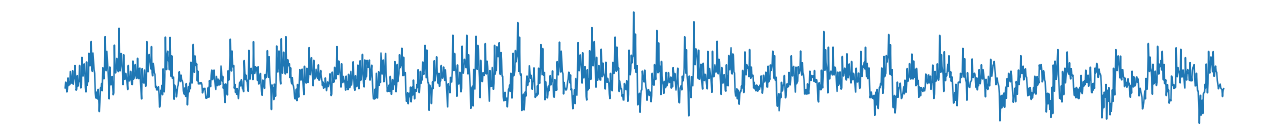

Epoch: 1 	 Discriminator Loss: [0.28777573, 0.884] 		 Generator Loss: 3.651336908340454
Epoch: 2 	 Discriminator Loss: [0.4303637, 0.824] 		 Generator Loss: 1.4510568380355835
Epoch: 3 	 Discriminator Loss: [1.0246507, 0.422] 		 Generator Loss: 1.601388931274414
Epoch: 4 	 Discriminator Loss: [1.35431, 0.27] 		 Generator Loss: 0.6582323312759399
Epoch: 5 	 Discriminator Loss: [0.8851818, 0.56] 		 Generator Loss: 1.5887572765350342


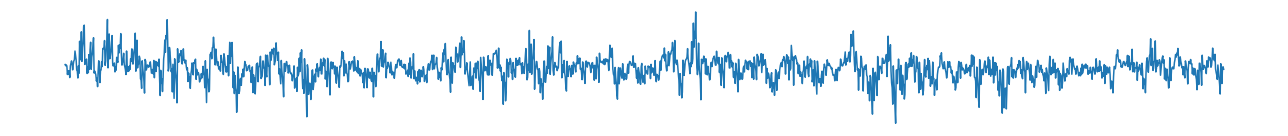

Epoch: 6 	 Discriminator Loss: [0.729377, 0.522] 		 Generator Loss: 1.1768800020217896
Epoch: 7 	 Discriminator Loss: [1.3695359, 0.296] 		 Generator Loss: 0.5114244222640991
Epoch: 8 	 Discriminator Loss: [0.8362433, 0.578] 		 Generator Loss: 0.8845574855804443
Epoch: 9 	 Discriminator Loss: [0.47668177, 0.822] 		 Generator Loss: 1.7038613557815552
Epoch: 10 	 Discriminator Loss: [0.6205148, 0.698] 		 Generator Loss: 1.912939190864563


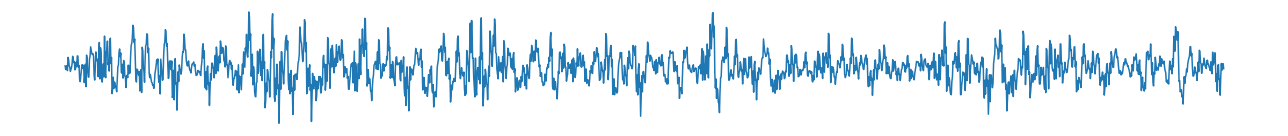

Epoch: 11 	 Discriminator Loss: [0.47007048, 0.796] 		 Generator Loss: 1.6522148847579956
Epoch: 12 	 Discriminator Loss: [0.8027019, 0.668] 		 Generator Loss: 0.6556253433227539
Epoch: 13 	 Discriminator Loss: [0.6246977, 0.716] 		 Generator Loss: 0.8793302178382874
Epoch: 14 	 Discriminator Loss: [0.5801325, 0.78] 		 Generator Loss: 0.9305476546287537
Epoch: 15 	 Discriminator Loss: [0.5665453, 0.748] 		 Generator Loss: 1.3018980026245117


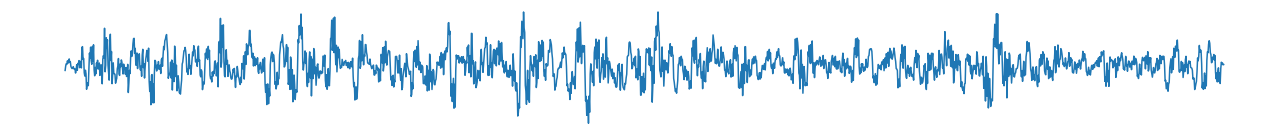

Epoch: 16 	 Discriminator Loss: [0.6988085, 0.592] 		 Generator Loss: 0.8395369052886963
Epoch: 17 	 Discriminator Loss: [0.38331255, 0.826] 		 Generator Loss: 1.9941444396972656
Epoch: 18 	 Discriminator Loss: [0.33492926, 0.848] 		 Generator Loss: 3.1880712509155273
Epoch: 19 	 Discriminator Loss: [0.63463396, 0.724] 		 Generator Loss: 3.4874720573425293
Epoch: 20 	 Discriminator Loss: [0.5547979, 0.742] 		 Generator Loss: 2.195768117904663


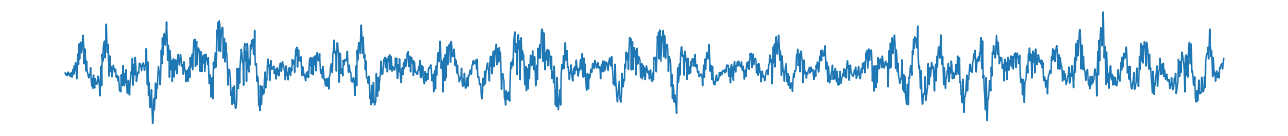

Epoch: 21 	 Discriminator Loss: [0.20209903, 0.942] 		 Generator Loss: 3.2784111499786377
Epoch: 22 	 Discriminator Loss: [0.7036543, 0.62] 		 Generator Loss: 1.2739412784576416
Epoch: 23 	 Discriminator Loss: [0.62959814, 0.66] 		 Generator Loss: 1.0997309684753418
Epoch: 24 	 Discriminator Loss: [0.44282973, 0.798] 		 Generator Loss: 1.5891307592391968
Epoch: 25 	 Discriminator Loss: [0.34513107, 0.834] 		 Generator Loss: 5.129273414611816


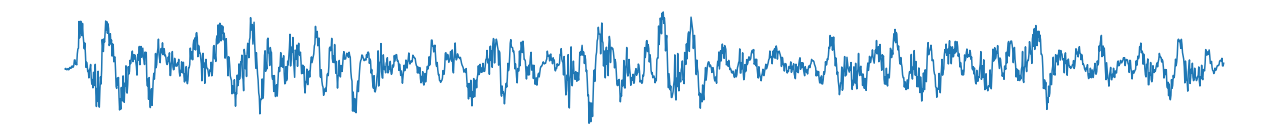

Epoch: 26 	 Discriminator Loss: [0.50947005, 0.742] 		 Generator Loss: 1.2554851770401
Epoch: 27 	 Discriminator Loss: [0.36042657, 0.848] 		 Generator Loss: 1.8883368968963623
Epoch: 28 	 Discriminator Loss: [0.39737692, 0.822] 		 Generator Loss: 2.4558753967285156
Epoch: 29 	 Discriminator Loss: [0.44482988, 0.798] 		 Generator Loss: 2.270585060119629
Epoch: 30 	 Discriminator Loss: [0.17995176, 0.926] 		 Generator Loss: 3.3625223636627197


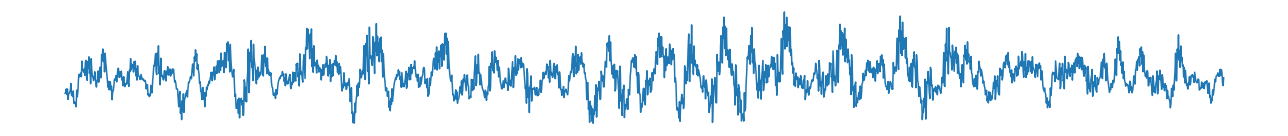

Epoch: 31 	 Discriminator Loss: [0.35012275, 0.836] 		 Generator Loss: 2.290546178817749
Epoch: 32 	 Discriminator Loss: [0.16670392, 0.946] 		 Generator Loss: 4.63442325592041
Epoch: 33 	 Discriminator Loss: [0.75459987, 0.644] 		 Generator Loss: 1.672597050666809
Epoch: 34 	 Discriminator Loss: [0.6507571, 0.658] 		 Generator Loss: 1.5956201553344727
Epoch: 35 	 Discriminator Loss: [0.08413224, 0.992] 		 Generator Loss: 7.778575420379639


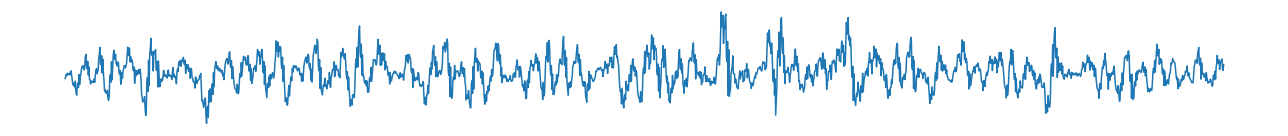

Epoch: 36 	 Discriminator Loss: [0.39514866, 0.824] 		 Generator Loss: 2.23331880569458
Epoch: 37 	 Discriminator Loss: [0.056076746, 0.988] 		 Generator Loss: 5.33556604385376
Epoch: 38 	 Discriminator Loss: [1.3636334, 0.314] 		 Generator Loss: 0.5148192644119263
Epoch: 39 	 Discriminator Loss: [0.41839603, 0.828] 		 Generator Loss: 1.2380452156066895
Epoch: 40 	 Discriminator Loss: [0.1551607, 0.968] 		 Generator Loss: 2.6288626194000244


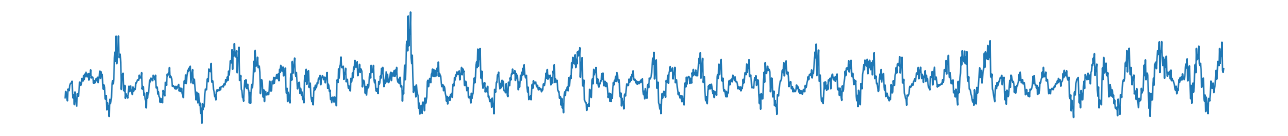

Epoch: 41 	 Discriminator Loss: [0.31575266, 0.866] 		 Generator Loss: 2.2886927127838135
Epoch: 42 	 Discriminator Loss: [0.31673107, 0.902] 		 Generator Loss: 2.1995768547058105
Epoch: 43 	 Discriminator Loss: [0.21259084, 0.93] 		 Generator Loss: 3.0300848484039307
Epoch: 44 	 Discriminator Loss: [0.3900449, 0.866] 		 Generator Loss: 2.6561219692230225
Epoch: 45 	 Discriminator Loss: [0.30755228, 0.898] 		 Generator Loss: 1.9644663333892822


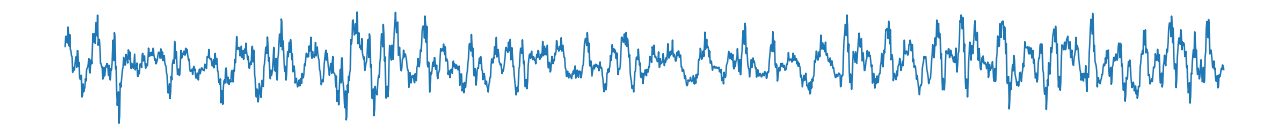

Epoch: 46 	 Discriminator Loss: [0.91324085, 0.666] 		 Generator Loss: 2.2296183109283447
Epoch: 47 	 Discriminator Loss: [0.4357682, 0.816] 		 Generator Loss: 1.9232518672943115
Epoch: 48 	 Discriminator Loss: [0.31678388, 0.878] 		 Generator Loss: 2.2548317909240723
Epoch: 49 	 Discriminator Loss: [0.5738717, 0.712] 		 Generator Loss: 1.687904715538025
Epoch: 50 	 Discriminator Loss: [0.30794948, 0.888] 		 Generator Loss: 2.097567081451416


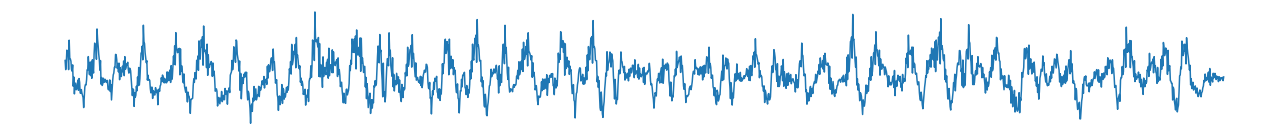

Epoch: 51 	 Discriminator Loss: [0.27816522, 0.898] 		 Generator Loss: 2.4464941024780273
Epoch: 52 	 Discriminator Loss: [0.6169606, 0.724] 		 Generator Loss: 1.404672384262085
Epoch: 53 	 Discriminator Loss: [0.7682416, 0.704] 		 Generator Loss: 2.2958366870880127
Epoch: 54 	 Discriminator Loss: [0.24930897, 0.932] 		 Generator Loss: 2.66272234916687
Epoch: 55 	 Discriminator Loss: [0.381596, 0.862] 		 Generator Loss: 1.5796030759811401


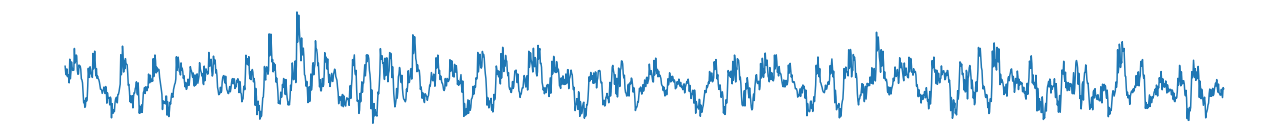

Epoch: 56 	 Discriminator Loss: [0.37633568, 0.834] 		 Generator Loss: 2.201862096786499
Epoch: 57 	 Discriminator Loss: [0.32186687, 0.89] 		 Generator Loss: 1.9106500148773193
Epoch: 58 	 Discriminator Loss: [0.91773206, 0.482] 		 Generator Loss: 1.3080343008041382
Epoch: 59 	 Discriminator Loss: [0.38119912, 0.862] 		 Generator Loss: 1.2911202907562256
Epoch: 60 	 Discriminator Loss: [0.3498712, 0.838] 		 Generator Loss: 1.9668227434158325


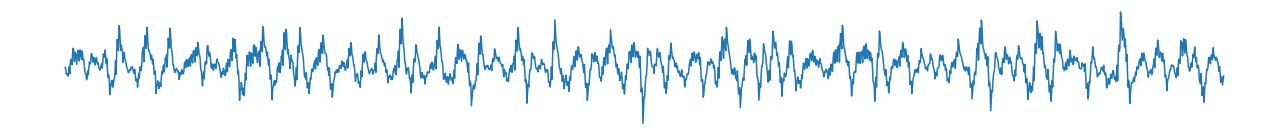

Epoch: 61 	 Discriminator Loss: [0.13078323, 0.958] 		 Generator Loss: 3.7594265937805176
Epoch: 62 	 Discriminator Loss: [0.14171837, 0.96] 		 Generator Loss: 2.899749517440796
Epoch: 63 	 Discriminator Loss: [0.18497825, 0.932] 		 Generator Loss: 2.814136266708374
Epoch: 64 	 Discriminator Loss: [0.69805765, 0.604] 		 Generator Loss: 4.614733695983887
Epoch: 65 	 Discriminator Loss: [1.475793, 0.192] 		 Generator Loss: 0.8106187582015991


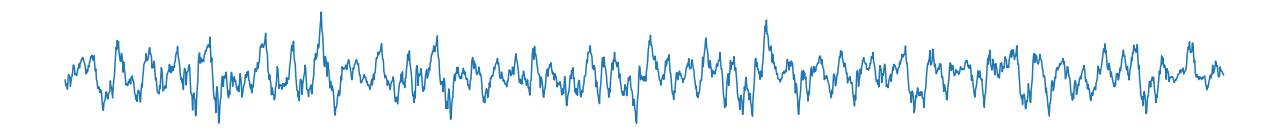

Epoch: 66 	 Discriminator Loss: [0.3345858, 0.896] 		 Generator Loss: 1.7489584684371948
Epoch: 67 	 Discriminator Loss: [0.39195743, 0.892] 		 Generator Loss: 1.303667426109314
Epoch: 68 	 Discriminator Loss: [0.556532, 0.806] 		 Generator Loss: 1.2692925930023193
Epoch: 69 	 Discriminator Loss: [0.1809468, 0.966] 		 Generator Loss: 2.2339766025543213
Epoch: 70 	 Discriminator Loss: [0.3063773, 0.912] 		 Generator Loss: 1.889327883720398


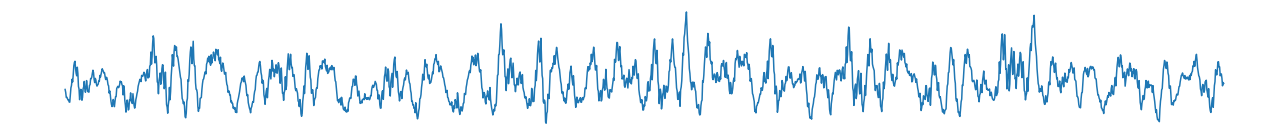

Epoch: 71 	 Discriminator Loss: [1.0692753, 0.696] 		 Generator Loss: 1.8334259986877441
Epoch: 72 	 Discriminator Loss: [0.12733787, 0.986] 		 Generator Loss: 2.896090269088745
Epoch: 73 	 Discriminator Loss: [0.17680736, 0.964] 		 Generator Loss: 2.220228910446167
Epoch: 74 	 Discriminator Loss: [0.550853, 0.812] 		 Generator Loss: 1.9334911108016968
Epoch: 75 	 Discriminator Loss: [0.20312527, 0.918] 		 Generator Loss: 3.021705389022827


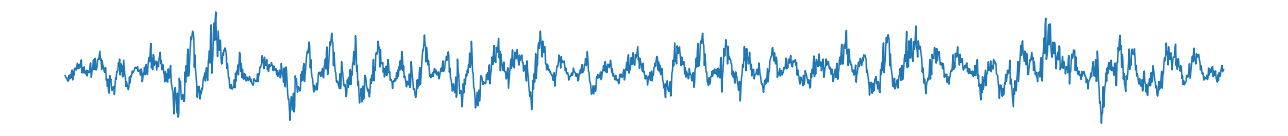

Epoch: 76 	 Discriminator Loss: [0.678278, 0.746] 		 Generator Loss: 4.208405017852783
Epoch: 77 	 Discriminator Loss: [0.991193, 0.63] 		 Generator Loss: 6.397397518157959
Epoch: 78 	 Discriminator Loss: [0.20267962, 0.942] 		 Generator Loss: 3.8410494327545166
Epoch: 79 	 Discriminator Loss: [0.21479821, 0.946] 		 Generator Loss: 2.177475690841675
Epoch: 80 	 Discriminator Loss: [0.16194302, 0.948] 		 Generator Loss: 2.6211719512939453


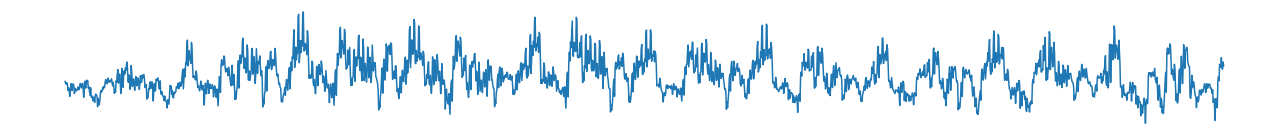

Epoch: 81 	 Discriminator Loss: [0.21374981, 0.934] 		 Generator Loss: 2.529986619949341
Epoch: 82 	 Discriminator Loss: [0.103230245, 0.974] 		 Generator Loss: 3.174009323120117
Epoch: 83 	 Discriminator Loss: [0.3194164, 0.91] 		 Generator Loss: 1.400933861732483
Epoch: 84 	 Discriminator Loss: [0.1889998, 0.934] 		 Generator Loss: 3.5826475620269775
Epoch: 85 	 Discriminator Loss: [0.09777067, 0.982] 		 Generator Loss: 3.075011968612671


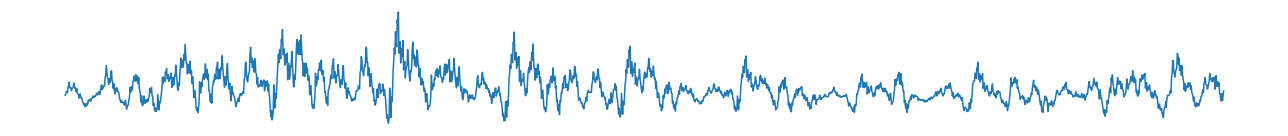

Epoch: 86 	 Discriminator Loss: [0.14351739, 0.954] 		 Generator Loss: 2.9682676792144775
Epoch: 87 	 Discriminator Loss: [0.4098271, 0.872] 		 Generator Loss: 2.884014129638672
Epoch: 88 	 Discriminator Loss: [0.69383043, 0.776] 		 Generator Loss: 3.154531240463257
Epoch: 89 	 Discriminator Loss: [0.19922312, 0.928] 		 Generator Loss: 3.8110485076904297
Epoch: 90 	 Discriminator Loss: [0.7543908, 0.552] 		 Generator Loss: 1.0458945035934448


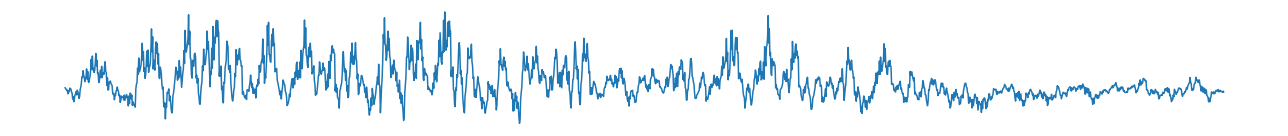

Epoch: 91 	 Discriminator Loss: [0.20927197, 0.954] 		 Generator Loss: 2.386569023132324
Epoch: 92 	 Discriminator Loss: [0.10503034, 0.98] 		 Generator Loss: 2.7305893898010254
Epoch: 93 	 Discriminator Loss: [0.23116495, 0.92] 		 Generator Loss: 2.5298333168029785
Epoch: 94 	 Discriminator Loss: [0.5375739, 0.826] 		 Generator Loss: 1.234106421470642
Epoch: 95 	 Discriminator Loss: [2.5269496, 0.282] 		 Generator Loss: 11.659953117370605


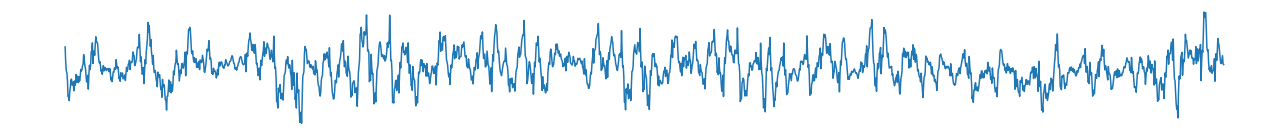

Epoch: 96 	 Discriminator Loss: [2.24166, 0.482] 		 Generator Loss: 1.4954441785812378
Epoch: 97 	 Discriminator Loss: [1.1871246, 0.57] 		 Generator Loss: 1.8626850843429565
Epoch: 98 	 Discriminator Loss: [0.8258728, 0.618] 		 Generator Loss: 0.880200982093811
Epoch: 99 	 Discriminator Loss: [0.90410376, 0.666] 		 Generator Loss: 0.8630431890487671
Epoch: 100 	 Discriminator Loss: [0.5182893, 0.788] 		 Generator Loss: 1.4898650646209717


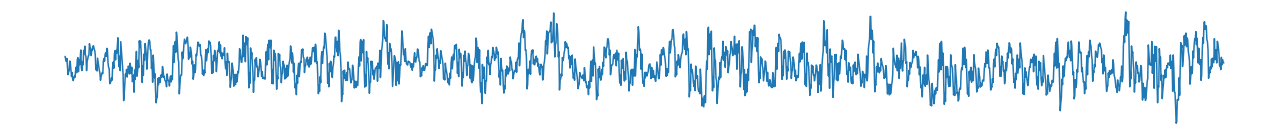

Epoch: 101 	 Discriminator Loss: [1.3611989, 0.288] 		 Generator Loss: 0.6774640083312988
Epoch: 102 	 Discriminator Loss: [0.70612794, 0.646] 		 Generator Loss: 1.052518367767334
Epoch: 103 	 Discriminator Loss: [0.668283, 0.67] 		 Generator Loss: 0.9443987011909485
Epoch: 104 	 Discriminator Loss: [0.6854145, 0.636] 		 Generator Loss: 0.9164358973503113
Epoch: 105 	 Discriminator Loss: [0.61648804, 0.712] 		 Generator Loss: 0.9325934052467346


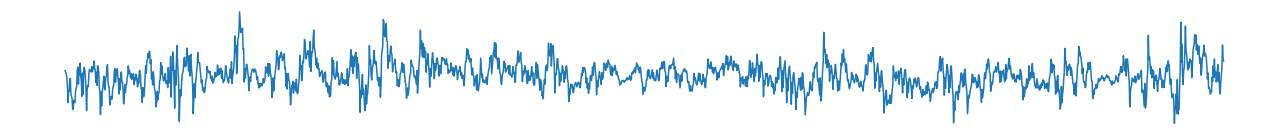

Epoch: 106 	 Discriminator Loss: [0.759853, 0.568] 		 Generator Loss: 0.7809229493141174
Epoch: 107 	 Discriminator Loss: [0.70299864, 0.548] 		 Generator Loss: 0.7760468125343323
Epoch: 108 	 Discriminator Loss: [0.7795992, 0.472] 		 Generator Loss: 0.6306450366973877
Epoch: 109 	 Discriminator Loss: [0.85375994, 0.35] 		 Generator Loss: 0.6844933032989502
Epoch: 110 	 Discriminator Loss: [1.1507405, 0.174] 		 Generator Loss: 0.5293298363685608


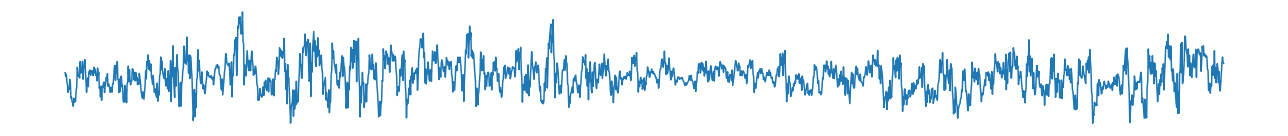

Epoch: 111 	 Discriminator Loss: [0.25260416, 0.944] 		 Generator Loss: 2.4367382526397705
Epoch: 112 	 Discriminator Loss: [0.52917296, 0.8] 		 Generator Loss: 1.0514899492263794
Epoch: 113 	 Discriminator Loss: [0.6809021, 0.614] 		 Generator Loss: 0.884946882724762
Epoch: 114 	 Discriminator Loss: [0.7592003, 0.554] 		 Generator Loss: 0.8848830461502075
Epoch: 115 	 Discriminator Loss: [0.6617652, 0.564] 		 Generator Loss: 0.8823385238647461


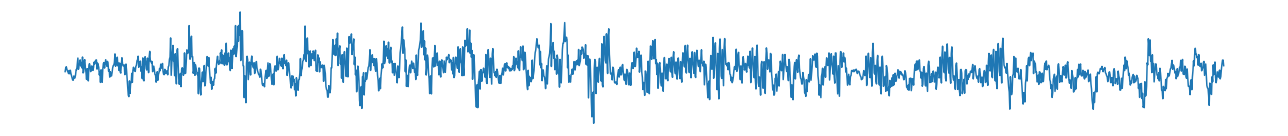

Epoch: 116 	 Discriminator Loss: [0.6325297, 0.72] 		 Generator Loss: 0.7743563652038574
Epoch: 117 	 Discriminator Loss: [0.6148359, 0.744] 		 Generator Loss: 0.7112081050872803
Epoch: 118 	 Discriminator Loss: [0.4556485, 0.932] 		 Generator Loss: 1.0418375730514526
Epoch: 119 	 Discriminator Loss: [0.5513617, 0.792] 		 Generator Loss: 0.9659790992736816
Epoch: 120 	 Discriminator Loss: [0.47254738, 0.888] 		 Generator Loss: 1.034255862236023


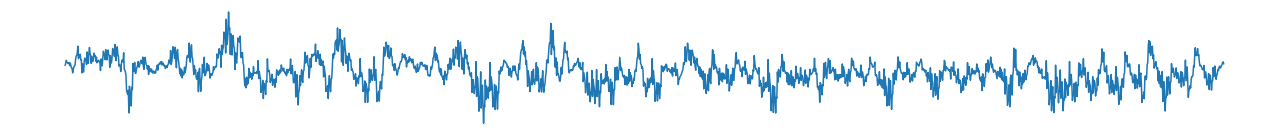

Epoch: 121 	 Discriminator Loss: [0.5699951, 0.764] 		 Generator Loss: 0.9409098029136658
Epoch: 122 	 Discriminator Loss: [0.6568679, 0.588] 		 Generator Loss: 0.7684773802757263
Epoch: 123 	 Discriminator Loss: [0.5444493, 0.716] 		 Generator Loss: 1.007673978805542
Epoch: 124 	 Discriminator Loss: [0.6883307, 0.558] 		 Generator Loss: 0.8973891735076904
Epoch: 125 	 Discriminator Loss: [0.0696644, 1.0] 		 Generator Loss: 2.742868661880493


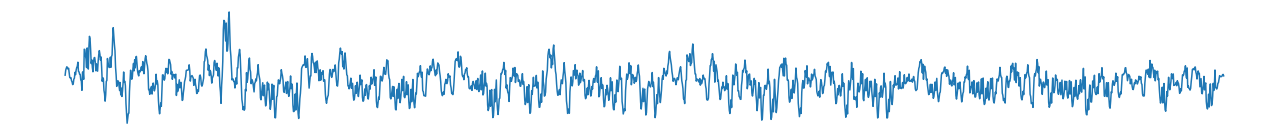

Epoch: 126 	 Discriminator Loss: [0.23676628, 0.958] 		 Generator Loss: 2.141728401184082
Epoch: 127 	 Discriminator Loss: [0.91147983, 0.294] 		 Generator Loss: 0.6677435636520386
Epoch: 128 	 Discriminator Loss: [0.6391466, 0.662] 		 Generator Loss: 0.9696499109268188
Epoch: 129 	 Discriminator Loss: [1.0877007, 0.284] 		 Generator Loss: 0.618036687374115
Epoch: 130 	 Discriminator Loss: [0.6582, 0.63] 		 Generator Loss: 1.0244874954223633


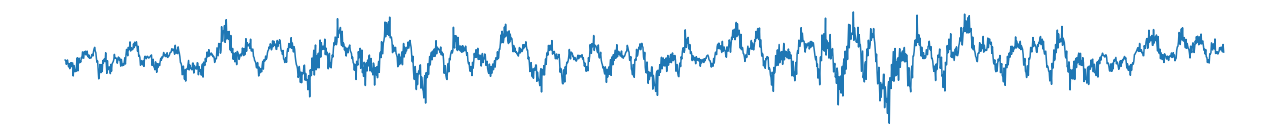

Epoch: 131 	 Discriminator Loss: [0.57937145, 0.716] 		 Generator Loss: 1.4176654815673828
Epoch: 132 	 Discriminator Loss: [0.52075976, 0.834] 		 Generator Loss: 0.9250872731208801
Epoch: 133 	 Discriminator Loss: [0.8137093, 0.4] 		 Generator Loss: 0.6870224475860596
Epoch: 134 	 Discriminator Loss: [0.8820588, 0.498] 		 Generator Loss: 0.9375105500221252
Epoch: 135 	 Discriminator Loss: [0.91772085, 0.104] 		 Generator Loss: 0.6298431158065796


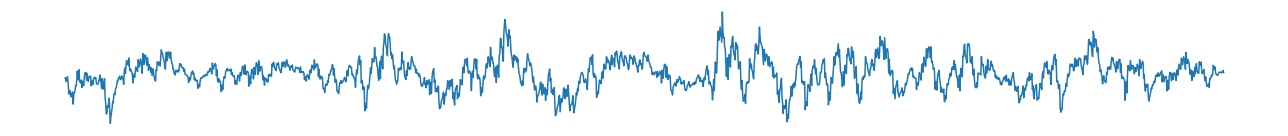

Epoch: 136 	 Discriminator Loss: [1.1591287, 0.264] 		 Generator Loss: 0.5457157492637634
Epoch: 137 	 Discriminator Loss: [0.77095896, 0.342] 		 Generator Loss: 0.7049301862716675
Epoch: 138 	 Discriminator Loss: [0.71371424, 0.5] 		 Generator Loss: 0.7719613909721375
Epoch: 139 	 Discriminator Loss: [0.6484893, 0.564] 		 Generator Loss: 0.8245973587036133
Epoch: 140 	 Discriminator Loss: [0.63499856, 0.812] 		 Generator Loss: 0.800094485282898


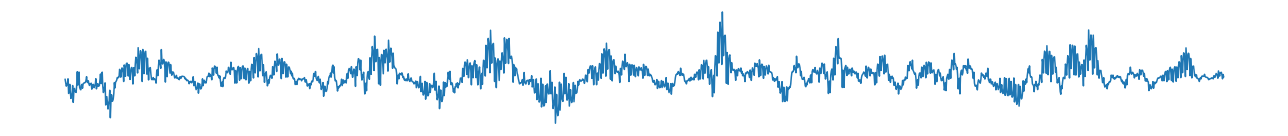

Epoch: 141 	 Discriminator Loss: [0.67530787, 0.642] 		 Generator Loss: 0.7233530282974243
Epoch: 142 	 Discriminator Loss: [0.68404776, 0.61] 		 Generator Loss: 0.7554869651794434
Epoch: 143 	 Discriminator Loss: [0.68280673, 0.544] 		 Generator Loss: 0.7266746759414673
Epoch: 144 	 Discriminator Loss: [0.69052845, 0.508] 		 Generator Loss: 0.7094473242759705
Epoch: 145 	 Discriminator Loss: [0.70475435, 0.496] 		 Generator Loss: 0.7093061804771423


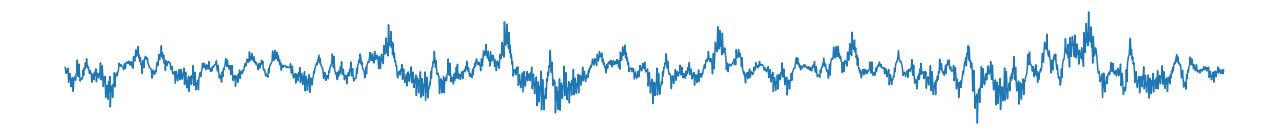

Epoch: 146 	 Discriminator Loss: [0.74864876, 0.336] 		 Generator Loss: 0.6290735006332397
Epoch: 147 	 Discriminator Loss: [0.6775457, 0.646] 		 Generator Loss: 0.6251785159111023
Epoch: 148 	 Discriminator Loss: [0.7888231, 0.478] 		 Generator Loss: 0.7458280920982361
Epoch: 149 	 Discriminator Loss: [0.6665758, 0.61] 		 Generator Loss: 0.7238113880157471
Epoch: 150 	 Discriminator Loss: [0.6899836, 0.542] 		 Generator Loss: 0.717812716960907


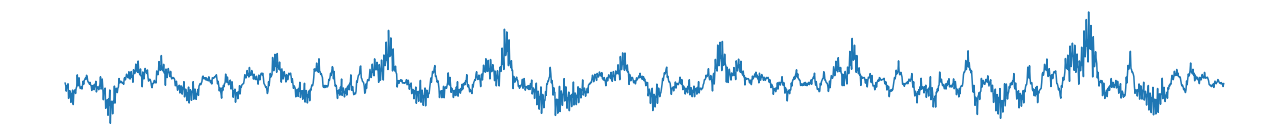

Epoch: 151 	 Discriminator Loss: [0.6843098, 0.516] 		 Generator Loss: 0.7320316433906555
Epoch: 152 	 Discriminator Loss: [0.6918071, 0.566] 		 Generator Loss: 0.8265813589096069
Epoch: 153 	 Discriminator Loss: [0.6698375, 0.648] 		 Generator Loss: 0.6919431090354919
Epoch: 154 	 Discriminator Loss: [0.69867605, 0.51] 		 Generator Loss: 0.7269577383995056
Epoch: 155 	 Discriminator Loss: [0.67697036, 0.638] 		 Generator Loss: 0.7511481642723083


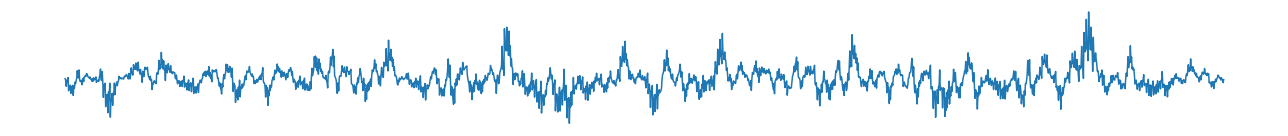

Epoch: 156 	 Discriminator Loss: [0.693922, 0.5] 		 Generator Loss: 0.6496943235397339
Epoch: 157 	 Discriminator Loss: [0.7015889, 0.47] 		 Generator Loss: 0.7164164781570435
Epoch: 158 	 Discriminator Loss: [0.6914688, 0.514] 		 Generator Loss: 0.7059701681137085
Epoch: 159 	 Discriminator Loss: [0.68874687, 0.54] 		 Generator Loss: 0.6759393215179443
Epoch: 160 	 Discriminator Loss: [0.692057, 0.552] 		 Generator Loss: 0.7069873213768005


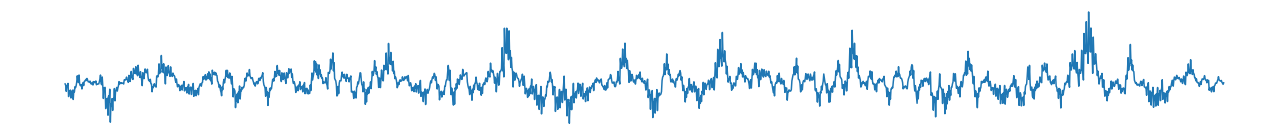

Epoch: 161 	 Discriminator Loss: [0.69399154, 0.464] 		 Generator Loss: 0.6855378150939941
Epoch: 162 	 Discriminator Loss: [0.6965746, 0.484] 		 Generator Loss: 0.6914799213409424
Epoch: 163 	 Discriminator Loss: [0.6926993, 0.512] 		 Generator Loss: 0.700026273727417
Epoch: 164 	 Discriminator Loss: [0.693232, 0.526] 		 Generator Loss: 0.6773825883865356
Epoch: 165 	 Discriminator Loss: [0.6929865, 0.498] 		 Generator Loss: 0.6909452676773071


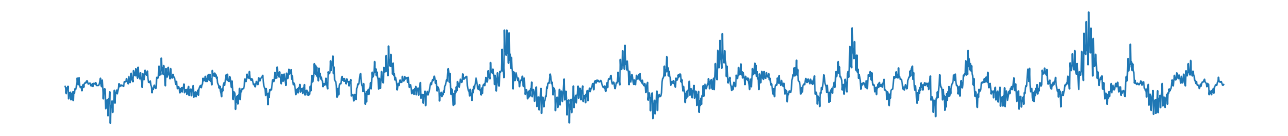

Epoch: 166 	 Discriminator Loss: [0.6917424, 0.522] 		 Generator Loss: 0.6729438900947571
Epoch: 167 	 Discriminator Loss: [0.69147104, 0.532] 		 Generator Loss: 0.7041438221931458
Epoch: 168 	 Discriminator Loss: [0.68346596, 0.604] 		 Generator Loss: 0.6836463809013367
Epoch: 169 	 Discriminator Loss: [0.7041287, 0.512] 		 Generator Loss: 0.6449449062347412
Epoch: 170 	 Discriminator Loss: [0.6930697, 0.552] 		 Generator Loss: 0.6947568655014038


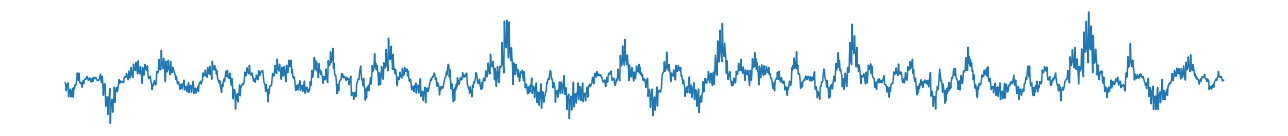

Epoch: 171 	 Discriminator Loss: [0.69197565, 0.554] 		 Generator Loss: 0.6890614628791809
Epoch: 172 	 Discriminator Loss: [0.6967671, 0.5] 		 Generator Loss: 0.8032922148704529
Epoch: 173 	 Discriminator Loss: [0.67900175, 0.568] 		 Generator Loss: 0.7620393633842468
Epoch: 174 	 Discriminator Loss: [0.6954708, 0.5] 		 Generator Loss: 0.6273027062416077
Epoch: 175 	 Discriminator Loss: [0.69314724, 0.5] 		 Generator Loss: 0.6931558847427368


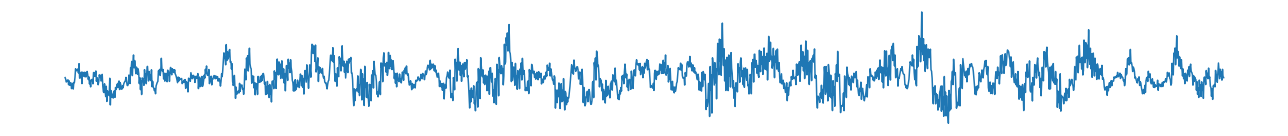

Epoch: 176 	 Discriminator Loss: [0.69314724, 0.5] 		 Generator Loss: 0.6931545734405518
Epoch: 177 	 Discriminator Loss: [0.69314724, 0.5] 		 Generator Loss: 0.693145215511322
Epoch: 178 	 Discriminator Loss: [0.69314724, 0.5] 		 Generator Loss: 0.6931471228599548
Epoch: 179 	 Discriminator Loss: [0.69314724, 0.5] 		 Generator Loss: 0.6931471228599548
Epoch: 180 	 Discriminator Loss: [0.69314724, 0.5] 		 Generator Loss: 0.6931471228599548


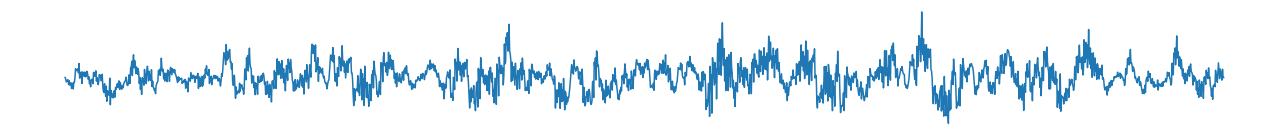

Epoch: 181 	 Discriminator Loss: [0.69314724, 0.5] 		 Generator Loss: 0.6931472420692444
Epoch: 182 	 Discriminator Loss: [0.69314724, 0.5] 		 Generator Loss: 0.6931472420692444
Epoch: 183 	 Discriminator Loss: [0.69314724, 0.5] 		 Generator Loss: 0.6931472420692444
Epoch: 184 	 Discriminator Loss: [0.69314724, 0.5] 		 Generator Loss: 0.6931823492050171
Epoch: 185 	 Discriminator Loss: [0.69314724, 0.5] 		 Generator Loss: 0.6931533217430115


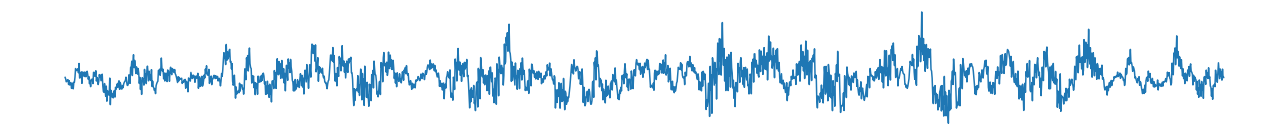

Epoch: 186 	 Discriminator Loss: [0.69314724, 0.5] 		 Generator Loss: 0.6931472420692444
Epoch: 187 	 Discriminator Loss: [0.69314724, 0.5] 		 Generator Loss: 0.6931472420692444
Epoch: 188 	 Discriminator Loss: [0.69314724, 0.5] 		 Generator Loss: 0.6931472420692444
Epoch: 189 	 Discriminator Loss: [0.69314724, 0.5] 		 Generator Loss: 0.6931472420692444
Epoch: 190 	 Discriminator Loss: [0.69314724, 0.5] 		 Generator Loss: 0.6931458711624146


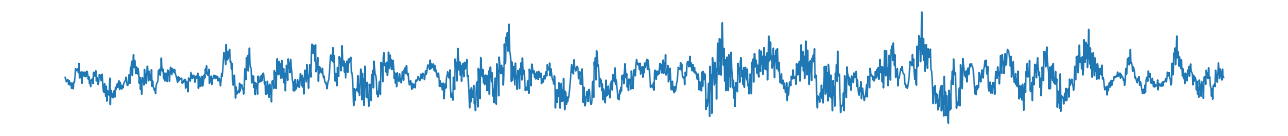

Epoch: 191 	 Discriminator Loss: [0.69314724, 0.5] 		 Generator Loss: 0.6931471228599548
Epoch: 192 	 Discriminator Loss: [0.69314724, 0.5] 		 Generator Loss: 0.6931471228599548
Epoch: 193 	 Discriminator Loss: [0.69314724, 0.5] 		 Generator Loss: 0.6931471228599548
Epoch: 194 	 Discriminator Loss: [0.69314724, 0.5] 		 Generator Loss: 0.6931471228599548
Epoch: 195 	 Discriminator Loss: [0.69314724, 0.5] 		 Generator Loss: 0.6931471228599548


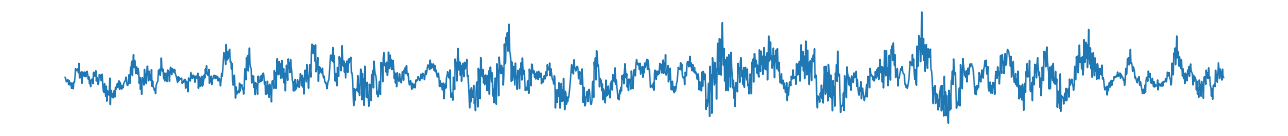

Epoch: 196 	 Discriminator Loss: [0.69314724, 0.5] 		 Generator Loss: 0.6931471228599548
Epoch: 197 	 Discriminator Loss: [0.69314724, 0.5] 		 Generator Loss: 0.6931471228599548
Epoch: 198 	 Discriminator Loss: [0.69314724, 0.5] 		 Generator Loss: 0.6931471228599548
Epoch: 199 	 Discriminator Loss: [0.6931472, 0.5] 		 Generator Loss: 0.6931480765342712
Epoch: 200 	 Discriminator Loss: [0.69314724, 0.5] 		 Generator Loss: 0.6931472420692444


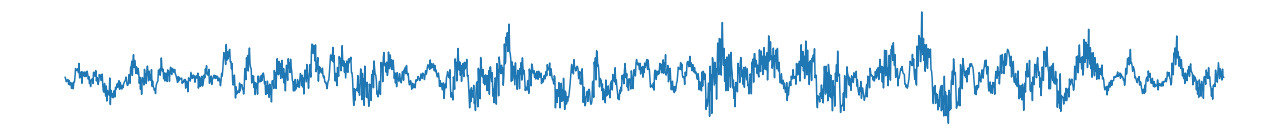

Epoch: 201 	 Discriminator Loss: [0.69314724, 0.5] 		 Generator Loss: 0.6931472420692444


KeyboardInterrupt: 

In [119]:
disc_losses = []
disc_accuracies = []
gen_losses = []
def train_disc(epochs, batch_size, gen, disc):
    steps_per_epoch = round(50000//250*(1-validation_split))
    for epoch in range(epochs):
        for batch in range(steps_per_epoch):
            noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
            real_trajs = db_train[np.arange(batch*batch_size, (batch+1)*batch_size)]
            fake_trajs = gen.predict(noise)
            trajs = np.concatenate((real_trajs, fake_trajs))
            
            disc_labels = np.zeros(2*batch_size)
            disc_labels[:batch_size] = 0.9
            disc_loss = disc.train_on_batch(trajs, disc_labels) # training del discriminatore (gli dico quali sono vere e quali no)            
            print(f'Epoch:{epoch}, batch:{batch}/{steps_per_epoch}', end="\r")
        print(f'Epoch: {epoch} \t Discriminator Loss: {disc_loss}')

def train_gan(epochs, batch_size, gen, disc, gan):
    static_noise = np.random.normal(0, 1, size=(1, noise_dim))
    steps_per_epoch = round(50000//250*(1-validation_split))
    for epoch in range(epochs):
        for batch in range(steps_per_epoch):
            noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
            real_trajs = db_train[np.arange(batch*batch_size, (batch+1)*batch_size)]
            fake_trajs = gen.predict(noise)
            trajs = np.concatenate((real_trajs, fake_trajs))
            
            disc_labels = np.zeros(2*batch_size)
            disc_labels[:batch_size] = 1.0
            disc_loss = disc.train_on_batch(trajs, disc_labels) # training del discriminatore (gli dico quali sono vere e quali no)
    
            gen_labels = np.ones(batch_size)
            gen_loss = gan.train_on_batch(noise, gen_labels) # training del generatore (per imbrogliare il discrim.)
            
            print(f'Epoch:{epoch}, batch:{batch}/{steps_per_epoch}', end="\r")
        print(f'Epoch: {epoch} \t Discriminator Loss: {disc_loss} \t\t Generator Loss: {gen_loss}')
        disc_losses.append(disc_loss[0])
        disc_accuracies.append(disc_loss[1])
        gen_losses.append(gen_loss)
        if epoch%5==0:  plot_trajs(static_noise)

batch_size = 250
train_gan(epochs=1000, batch_size=batch_size, gen=gen, disc=disc, gan=gan)
#train_disc(epochs=20, batch_size=batch_size, gen=gen, disc=disc)

# Testing

In [120]:
noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
disc.evaluate(gen.predict(noise),np.zeros(batch_size))
disc.evaluate(db_train[np.random.randint(50000*(1-validation_split),size=batch_size)],np.ones(batch_size))

250/250 [==============================] - 0s 103us/sample - loss: 0.6931 - binary_accuracy: 0.0000e+00


[0.6931472420692444, 0.0]

In [ ]:
#disc.predict(gen.predict(noise))
disc.predict(db_train[np.random.randint(50000*(1-validation_split),size=batch_size)])

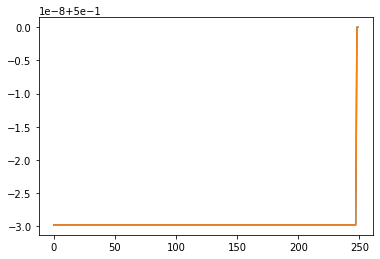

In [122]:
plt.plot(disc.predict(gen.predict(noise)))
plt.plot(disc.predict(db_train[np.random.randint(50000*(1-validation_split),size=batch_size)]))

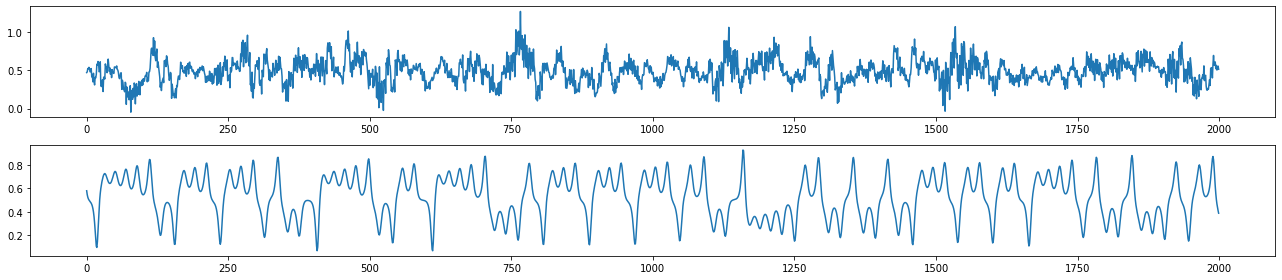

In [123]:
static_noise = np.random.normal(0, 1, size=(1, noise_dim))
plot_trajs(static_noise, db_train)

# Saving

In [124]:
disc.save('gan_disc_prova.h5')
gen.save('gan_gen_prova.h5')
#from tensorflow.keras.models import load_model
#disc = load_model('classificatore.h5')